In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.Chem import AllChem
from functools import partial
import pickle as pk

DOV_DICT = pk.load(
    open("DOV_4degree_256nBits_05dpm.pk", "rb")
)

DPM = 0.05
RADIUS = 4
NBITS=256

def get_num_missing_features_full(smi, pm, dpm, DOV_dict, radius=4, nBits=256):
    num_missing_features = 0
    
    m = AllChem.MolFromSmiles(smi)
    fp = AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits)
    
    for i, key in enumerate(fp.GetNonzeroElements()):
        if key not in DOV_dict:
            num_missing_features += 1
        else:
            matching_pm = False
            for pm_loc in DOV_dict[key]:
                min_pm = pm_loc-dpm
                max_pm = pm_loc+dpm
                if min_pm <= pm and pm <= max_pm:
                    matching_pm = True
                    break
            
            if not matching_pm:
                num_missing_features += 1
    
    return num_missing_features

get_num_missing_features = partial(get_num_missing_features_full, dpm=DPM, DOV_dict=DOV_DICT, radius=RADIUS, nBits=NBITS)


# Make Predictions

In [2]:
from functools import partial
import multiprocessing as mp
import numpy as np
import pandas as pd
from m2p.polymaker import PolyMaker
from stereochem_utils import get_stereoester_df, get_single_hydroxyacid_chiral_smiles

from polyml import MultiModel
from nfp.preprocessing.features import *
from polyml.preprocessors import PolymerPreprocessor, PmMnExistPreprocessor, PmPreprocessor
from rdkit.Chem import AllChem
from rdkit.Chem import Draw


pm_model = MultiModel.load_models("220504_af64_bf64_mf8_mg10_DP25_R5_K10_global_pm/")
ctag_model = MultiModel.load_models("220504_af64_bf64_mf8_mg10_DP25_R5_K10_ctag/")

220504_af64_bf64_mf8_mg10_DP25_R5_K10_global_pm/parameters.pk


2024-01-15 19:11:59.628996: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


220504_af64_bf64_mf8_mg10_DP25_R5_K10_ctag/parameters.pk


In [3]:
def get_prepolymer(df_monomers, pm_values, distribution=["1:1"]):
    # df_monomers is a df with smiles
    poma = PolyMaker()

    df_monomers = get_stereoester_df(df_monomers, False)

    # Initialize polymer dataframes
    df_homo_pre = pd.DataFrame()
    df_homo = pd.DataFrame()

    monomer_smiles = []
    for _, row in df_monomers.iterrows():
        for pm in pm_values:
            if ".." in row.smiles_monomer:
                dist = distribution
            else:
                dist = []
            monomer_smiles.append(
                {
                    "smiles_monomer": row.smiles_monomer,
                    "smiles_stereo": row.smiles_stereo,
                    "pm": pm,
                    "mechanism": "ester_stereo",
                    "distribution": dist
                }
            )
    df_homo_pre = pd.DataFrame(monomer_smiles)

    return df_homo_pre

def get_precopolymer(df_monomers, pm_values, distribution=["1:1"]):
    # df_monomers is a df with smiles
    poma = PolyMaker()

    # Initialize polymer dataframes
    df_copo_pre = pd.DataFrame()

    monomer_smiles = []
    for _, row in df_monomers.iterrows():
        for pm in pm_values:
            if ".." in row.smiles_monomer:
                dist = distribution
            else:
                dist = []
            monomer_smiles.append(
                {
                    "smiles_monomer": row.smiles_monomer,
                    "smiles_stereo": row.smiles_stereo,
                    "pm": pm,
                    "mechanism": "ester_stereo",
                    "distribution": dist
                }
            )
    df_homo_pre = pd.DataFrame(monomer_smiles)

    return df_homo_pre

def get_polymerized_df(df_prepolymer, DP=21, replicates=5, n_processes=1, distribution=[]):
    poma = PolyMaker()
    #####
    # Get Polymer DFs
    # Define polymerization partial function
    partial_thermoplastic = partial(
        poma.thermoplastic_stereo,
        DP=DP,
        replicate_structures=replicates,
        distribution=[],
        verbose=False
    )
    df_polymer = pd.DataFrame()

    df_prepolymer.fillna(value={"distribution": "[]"})

    # Polymerize Homopolymers
    df_prepolymer["monomers"] = df_prepolymer["smiles_stereo"].map(poma.get_monomers)
    df_prepolymer["replicate_structures"] = replicates
    df_prepolymer["mechanism"] = "ester_stereo"
    df_prepolymer["distribution"] = df_prepolymer["distribution"].map(str)

    df_list = []
    with mp.Pool(n_processes) as pool:
        for i, res in enumerate(pool.map(partial_thermoplastic, np.array_split(df_prepolymer, n_processes))):
            df_list.append(res)

    df_out = pd.concat(df_list)
    
    return df_out


# Generate Structures

## 1. Polycondensation
We need to make AABA polymers. To do this we can generate the RR.SS.RR.SS polymers and synthesize those manually

In [4]:
mandelic_acid = "OC(=O)C(O)c1ccccc1"
tropic_acid = "OC(=O)C(CO)c1ccccc1"
methoxy_mandelic_acid = "OC(=O)C(O)c1c(OC)cccc1"
lactic_acid = "OC(=O)C(O)C"
glycolic_acid = "OC(=O)CO"
mandelic_glycolic = "OC(=O)COC(=O)C(O)c1ccccc1"
tropic_glycolic = "OC(=O)COC(=O)C(CO)c1ccccc1"
methoxy_mandelic_glycolic = "OC(=O)COC(=O)C(O)c1c(OC)cccc1"

RR_isotactic_copolymer = "OC([C@@H](C1=CC=CC=C1)O[C@@H](C)C(O)=O)=O.OC([C@@H](C1=CC=CC=C1)O[C@@H](C)C(O)=O)=O"
SS_isotactic_copolymer = "OC([C@H](C1=CC=CC=C1)O[C@H](C)C(O)=O)=O.OC([C@H](C1=CC=CC=C1)O[C@H](C)C(O)=O)=O"
RR_SS_alt_copolymer = "OC([C@@H](C)O[C@@H](C1=CC=CC=C1)C(OC([C@H](C)O[C@H](C2=CC=CC=C2)C(O)=O)=O)=O)=O.OC([C@@H](C)O[C@@H](C1=CC=CC=C1)C(OC([C@H](C)O[C@H](C2=CC=CC=C2)C(O)=O)=O)=O)=O"
RR_SS_mol_control = "OC([C@@H](C)O[C@@H](C1=CC=CC=C1)C([O])=O)=O.OC([C@@H](C)O[C@@H](C1=CC=CC=C1)C([O])=O)=O..[O]C([C@H](C)O[C@H](C)C(O)=O)=O.[O]C([C@H](C)O[C@H](C)C(O)=O)=O"

PMLA = "O=C(O)C(OC(C(C)O)=O)C1=CC=CC=C1"
MA_co_LA = "..".join([mandelic_acid, lactic_acid])

df_homo_monomers = pd.DataFrame([methoxy_mandelic_acid, methoxy_mandelic_glycolic, tropic_acid, tropic_glycolic, mandelic_acid, mandelic_glycolic, lactic_acid], columns=["smiles_monomer"])

In [5]:
df_homo_pre = get_prepolymer(df_homo_monomers, pm_values=[0, 0.5, 1])
df_homo_poly = get_polymerized_df(df_homo_pre, distribution=[])

# df_homo_poly = pd.concat([df_homo_poly, pd.DataFrame([["O=C([C@H](c1ccccc1)O)O[C@H](C)C(O[C@@H](c2ccccc2)C(O[C@H](C)C(O[C@@H](c3ccccc3)C(O[C@H](C)C(O[C@@H](c4ccccc4)C(O[C@H](C)C(O[C@@H](c5ccccc5)C(O[C@H](C)C(O[C@@H](c6ccccc6)C(O[C@H](C)C(O[C@@H](c7ccccc7)C(O[C@H](C)C(O[C@@H](c8ccccc8)C(O[C@H](C)C(O[C@@H](c9ccccc9)C(O[C@H](C)C(O[C@@H](c%10ccccc%10)C(O[C@H](C)C(O[C@@H](c%11ccccc%11)C(O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O", 
#                                   "sPMLA", "sPMLA", 0.0, "ester_stereo", "[]", "sPMLA", 21, 0]], columns=df_homo_poly.columns)])

# df_homo_poly = pd.concat([df_homo_poly, pd.DataFrame([["O=C([C@H](c1ccccc1)O)O[C@@H](C)C(O[C@@H](c2ccccc2)C(O[C@@H](C)C(O[C@@H](c3ccccc3)C(O[C@@H](C)C(O[C@@H](c4ccccc4)C(O[C@@H](C)C(O[C@@H](c5ccccc5)C(O[C@@H](C)C(O[C@@H](c6ccccc6)C(O[C@@H](C)C(O[C@@H](c7ccccc7)C(O[C@@H](C)C(O[C@@H](c8ccccc8)C(O[C@@H](C)C(O[C@@H](c9ccccc9)C(O[C@@H](C)C(O[C@@H](c%10ccccc%10)C(O[C@@H](C)C(O[C@@H](c%11ccccc%11)C(O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O", 
#                                   "iPMLA", "iPMLA", 1.0, "ester_stereo", "[]", "iPMLA", 21, 0]], columns=df_homo_poly.columns)])

# df_homo_poly = pd.concat([df_homo_poly, pd.DataFrame([["O=C([C@H](c1ccccc1)O)O[C@@H](C)C(O[C@H](C)C(O[C@H](C)C(O[C@@H](c2ccccc2)C(O[C@@H](C)C(O[C@H](C)C(O[C@H](C)C(O[C@@H](c3ccccc3)C(O[C@@H](C)C(O[C@H](C)C(O[C@H](C)C(O[C@@H](c4ccccc4)C(O[C@@H](C)C(O[C@H](C)C(O[C@H](C)C(O[C@@H](c5ccccc5)C(O[C@@H](C)C(O[C@H](C)C(O[C@H](C)C(O[C@@H](c6ccccc6)C(O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O", 
                                #   "SS-MPDD-RR-Lac", "SS-MPDD-RR-Lac", 1.0, "SS-MPDD-RR-Lac", "[]", "SS-MPDD-RR-Lac", 21, 0]], columns=df_homo_poly.columns)])

# df_homo_poly = df_homo_poly.tail(3).reset_index(drop=True)
# df_homo_poly

## Predict Homopolymers

In [6]:
# df_ctag_homo_predictions_raw = ctag_model.make_predictions(df_homo_poly)
df_pm_homo_predictions_raw = pm_model.make_predictions(df_homo_poly)

2024-01-15 19:16:05.392083: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/Users/kevbot/Documents/local_packages/polyml/polyml/polyml.py:596: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_result)
/Users/kevbot/Documents/local_packages/polyml/polyml/polyml.py:596: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_result)
/Users/kevbot/Documents/local_packages/polyml/polyml/polyml.py:596: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_result)
/Users/kevbot/Documents/local_packages/polyml/polyml/polyml.py:596: FutureWarning: The frame.append method is

In [7]:
# df_homo_predictions_raw["missing_bits"] = df_homo_predictions_raw.apply(lambda r: get_num_missing_features(r.smiles_monomer, r.pm), axis=1)
# df_homo_predictions = df_homo_predictions_raw.groupby(
#     by=["smiles_monomer", "pm"]
#     ).agg("mean").reset_index().loc[:, ["smiles_monomer", "missing_bits", "pm", "Tm_pred", "Tg_pred"]].reset_index(drop=True)

df_pm_homo_predictions = df_pm_homo_predictions_raw.groupby(
    by=["smiles_monomer", "pm"]
    ).agg("mean").reset_index().loc[:, ["smiles_monomer", "pm", "Tm_pred", "Tg_pred"]].reset_index(drop=True)

# df_ctag_homo_predictions = df_ctag_homo_predictions_raw.groupby(
#     by=["smiles_monomer", "pm"]
#     ).agg("mean").reset_index().loc[:, ["smiles_monomer", "pm", "Tm_pred", "Tg_pred"]].reset_index(drop=True)


In [10]:
# df_pm_homo_predictions_raw.groupby(
#     by=["smiles_monomer", "pm"]
#     ).agg("mean").sort_values(by=["Tm_pred"],ascending=False)

In [11]:
# df_ctag_homo_predictions_raw.groupby(
#     by=["smiles_monomer", "pm"]
#     ).agg("mean")

## AABA Ring Opening
Manually Define The "homo" polymers first

In [13]:
RR_isotactic_copolymer = "OC([C@@H](C1=CC=CC=C1)O[C@@H](C)C(O)=O)=O.OC([C@@H](C1=CC=CC=C1)O[C@@H](C)C(O)=O)=O"
SS_isotactic_copolymer = "OC([C@H](C1=CC=CC=C1)O[C@H](C)C(O)=O)=O.OC([C@H](C1=CC=CC=C1)O[C@H](C)C(O)=O)=O"
RR_SS_alt_copolymer = "O=C([C@H](OC([C@@H](C)OC([C@@H](OC([C@H](C)O)=O)C1=CC=CC=C1)=O)=O)C2=CC=CC=C2)O.O=C([C@H](OC([C@@H](C)OC([C@@H](OC([C@H](C)O)=O)C1=CC=CC=C1)=O)=O)C2=CC=CC=C2)O"
RR_randHT_copolymer = "OC([C@@H](C1=CC=CC=C1)O[C@@H](C)C(O)=O)=O.O[C@H](C(OC([C@H](O)C)=O)=O)C1=CC=CC=C1"
RR_SS_mol_control = "OC([C@@H](C)O[C@@H](C1=CC=CC=C1)C([O])=O)=O.OC([C@@H](C)O[C@@H](C1=CC=CC=C1)C([O])=O)=O..[O]C([C@H](C)O[C@H](C)C(O)=O)=O.[O]C([C@H](C)O[C@H](C)C(O)=O)=O"

# df_RO_copo


In [14]:
SS_isotactic_copolymer = "O[C@@H](C)C(O[C@@H](C1=CC=CC=C1)C(O)=O)=O.O[C@@H](C)C(O[C@@H](C1=CC=CC=C1)C(O)=O)=O"
RR_isotactic_copolymer = "O[C@H](C)C(O[C@H](C1=CC=CC=C1)C(O)=O)=O.O[C@H](C)C(O[C@H](C1=CC=CC=C1)C(O)=O)=O"
RR_SS_alt_copolymer = "O=C([C@H](C)C(O[C@@H](C1=CC=CC=C1)C(O)=O)=O)[C@@H](C2=CC=CC=C2)OC([C@H](O)C)=O.O=C([C@H](C)C(O[C@@H](C1=CC=CC=C1)C(O)=O)=O)[C@@H](C2=CC=CC=C2)OC([C@H](O)C)=O"
RR_randHT_copolymer = "O[C@H](C)C(O[C@H](C1=CC=CC=C1)C(O)=O)=O.OC(C1=CC=CC=C1)C(O[C@@H](C)C(O)=O)=O"
RR_SS_mol_control = "OC([C@@H](C)O[C@@H](C1=CC=CC=C1)C([O])=O)=O.OC([C@@H](C)O[C@@H](C1=CC=CC=C1)C([O])=O)=O..[O]C([C@H](C)O[C@H](C)C(O)=O)=O.[O]C([C@H](C)O[C@H](C)C(O)=O)=O"

df_RO_pre = pd.DataFrame(
    [
        [
            "RR_isotactic_copolymer", RR_isotactic_copolymer, 1.0, "ester_stereo", "[]", RR_isotactic_copolymer, 1
        ],
        [
            "SS_isotactic_copolymer", SS_isotactic_copolymer, 1.0, "ester_stereo", "[]", SS_isotactic_copolymer, 1
        ],
        [
            "RR_SS_alt_copolymer", RR_SS_alt_copolymer, 0.5, "ester_stereo", "[]", RR_SS_alt_copolymer, 1
        ],
        [
            "RR_randHT_copolymer", RR_randHT_copolymer, 0.49, "ester_stereo", "[]", RR_randHT_copolymer, 1
        ]
    ],
    columns=df_homo_pre.columns
)
df_RO_poly = get_polymerized_df(df_RO_pre, distribution=[], replicates=1)

In [15]:
%%capture
df_ctag_RO_predictions_raw = ctag_model.make_predictions(df_RO_poly)
df_pm_RO_predictions_raw = pm_model.make_predictions(df_RO_poly)

In [16]:
df_pm_RO_predictions = df_pm_RO_predictions_raw.groupby(
    by=["smiles_monomer", "pm"]
    ).agg("mean").reset_index().loc[:, ["smiles_monomer", "pm", "Tm_pred", "Tg_pred"]].reset_index(drop=True)

df_ctag_RO_predictions = df_ctag_RO_predictions_raw.groupby(
    by=["smiles_monomer", "pm"]
    ).agg("mean").reset_index().loc[:, ["smiles_monomer", "pm", "Tm_pred", "Tg_pred"]].reset_index(drop=True)

In [17]:
list(set(df_pm_RO_predictions_raw.smiles_polymer[3]))[0]

'C[C@H](OC(=O)C(OC(=O)[C@H](C)OC(=O)C(OC(=O)[C@H](OC(=O)[C@@H](C)OC(=O)[C@H](OC(=O)[C@@H](C)O)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)C(=O)OC(C(=O)O[C@@H](C)C(=O)OC(C(=O)O[C@@H](C)C(=O)OC(C(=O)O[C@@H](C)C(=O)O[C@H](C)C(=O)O[C@@H](C(=O)OC(C(=O)O[C@@H](C)C(=O)OC(C(=O)O[C@@H](C)C(=O)OC(C(=O)O[C@@H](C)C(=O)OC(C(=O)O[C@@H](C)C(=O)O[C@H](C)C(=O)O[C@@H](C(=O)OC(C(=O)O[C@@H](C)C(=O)O[C@H](C)C(=O)O[C@@H](C(=O)O[C@H](C)C(=O)O[C@@H](C(=O)O[C@H](C)C(=O)O[C@@H](C(=O)OC(C(=O)O[C@@H](C)C(=O)O[C@H](C)C(=O)O[C@@H](C(=O)OC(C(=O)O[C@@H](C)C(=O)O[C@H](C)C(=O)O[C@@H](C(=O)O)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1)c1ccccc1'

In [18]:
df_pm_RO_predictions

,smiles_monomer,pm,Tm_pred,Tg_pred
0,RR_SS_alt_copolymer,0.50,99.399673,49.211124
1,RR_isotactic_copolymer,1.00,194.439270,74.466522
2,RR_randHT_copolymer,0.49,81.623291,29.506668
3,SS_isotactic_copolymer,1.00,193.004578,74.191475


In [19]:
df_ctag_RO_predictions

,smiles_monomer,pm,Tm_pred,Tg_pred
0,RR_SS_alt_copolymer,0.50,141.107513,69.610458
1,RR_isotactic_copolymer,1.00,147.696060,61.746708
2,RR_randHT_copolymer,0.49,119.263786,58.642338
3,SS_isotactic_copolymer,1.00,129.368668,61.255379


## Plot copolymers

In [20]:
polycondensation_copo = pd.DataFrame(data=[
    [mandelic_acid, lactic_acid],
    [methoxy_mandelic_acid, lactic_acid],
    [tropic_acid, lactic_acid]], columns=["primary", "secondary"])

polycondensation_copo["primary_stereo"] = polycondensation_copo.primary.apply(lambda smi: get_single_hydroxyacid_chiral_smiles(smi))
polycondensation_copo["secondary_stereo"] = polycondensation_copo.secondary.apply(lambda smi: get_single_hydroxyacid_chiral_smiles(smi))
polycondensation_copo["copo_smiles"] = polycondensation_copo.apply(lambda row: "..".join([row.primary_stereo, row.secondary_stereo]), axis=1)
polycondensation_copo["copo_monomers"] = polycondensation_copo.apply(lambda row: "..".join([row.primary, row.secondary]), axis=1)
df_copo = polycondensation_copo.loc[:, ["copo_monomers", "copo_smiles"]]
df_copo.columns = ["smiles_monomer", "smiles_stereo"]
df_copo_pre = pd.DataFrame()
for distro in ["[1,0]", "[0.75, 0.25]", "[0.5, 0.5]", "[0.25, 0.75]", "[0,1]"]:
    df_copo_pre = pd.concat([df_copo_pre, get_precopolymer(df_copo, pm_values=[0, 0.5, 1], distribution=distro)])

df_copo_pre = df_copo_pre.reset_index(drop=True)
df_copo_poly = get_polymerized_df(df_copo_pre, distribution=[])
# df_copo_poly
df_pm_copo_predictions_raw = pm_model.make_predictions(df_copo_poly)
# df_ctag_copo_predictions_raw = ctag_model.make_predictions(df_copo_poly)
# df_copo_poly

/Users/kevbot/Documents/local_packages/polyml/polyml/polyml.py:596: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_result)
/Users/kevbot/Documents/local_packages/polyml/polyml/polyml.py:596: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_result)
/Users/kevbot/Documents/local_packages/polyml/polyml/polyml.py:596: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_result)
/Users/kevbot/Documents/local_packages/polyml/polyml/polyml.py:596: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append(df_result)
/Users/kevbot/Docume

In [21]:
# df_copo_predictions_raw["missing_bits"] = df_copo_predictions_raw.apply(lambda r: get_num_missing_features(r.smiles_monomer, r.pm), axis=1)
df_copo_predictions = df_pm_copo_predictions_raw.groupby(
    by=["smiles_monomer", "pm", "distribution"]
    ).agg("mean").reset_index().loc[:, ["smiles_monomer", "pm", "distribution", "Tm_pred", "Tg_pred"]].reset_index(drop=True)

def get_copo_missing(smi, pm):
    missing_bits = [get_num_missing_features(s, pm) for s in smi.split("..")]
    return max(missing_bits)

# df_copo_predictions["missing_bits"] = df_copo_predictions.apply(lambda r: get_copo_missing(r.smiles_monomer, r.pm), axis=1)

df_copo_predictions.sort_values(by=["pm", "distribution"])

,smiles_monomer,pm,distribution,Tm_pred,Tg_pred
0,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,"[0,1]",167.489182,41.925285
15,OC(=O)C(O)c1c(OC)cccc1..OC(=O)C(O)C,0.0,"[0,1]",167.489182,41.925285
30,OC(=O)C(O)c1ccccc1..OC(=O)C(O)C,0.0,"[0,1]",167.405869,42.036007
1,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,"[0.25, 0.75]",159.684387,58.510471
16,OC(=O)C(O)c1c(OC)cccc1..OC(=O)C(O)C,0.0,"[0.25, 0.75]",189.412445,63.629852
31,OC(=O)C(O)c1ccccc1..OC(=O)C(O)C,0.0,"[0.25, 0.75]",152.479202,52.103916
2,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,"[0.5, 0.5]",162.467621,68.976418
17,OC(=O)C(O)c1c(OC)cccc1..OC(=O)C(O)C,0.0,"[0.5, 0.5]",199.329330,69.075867
32,OC(=O)C(O)c1ccccc1..OC(=O)C(O)C,0.0,"[0.5, 0.5]",152.722885,62.268398
3,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,"[0.75, 0.25]",169.719849,77.379227


In [22]:
df_copo_predictions["type"] = "copo"
df_homo_predictions["type"] = "homo"

df_predictions = pd.concat([df_copo_predictions, df_homo_predictions])
df_predictions.to_csv("../HomoCopoPredictions.csv")

NameError: name 'df_homo_predictions' is not defined

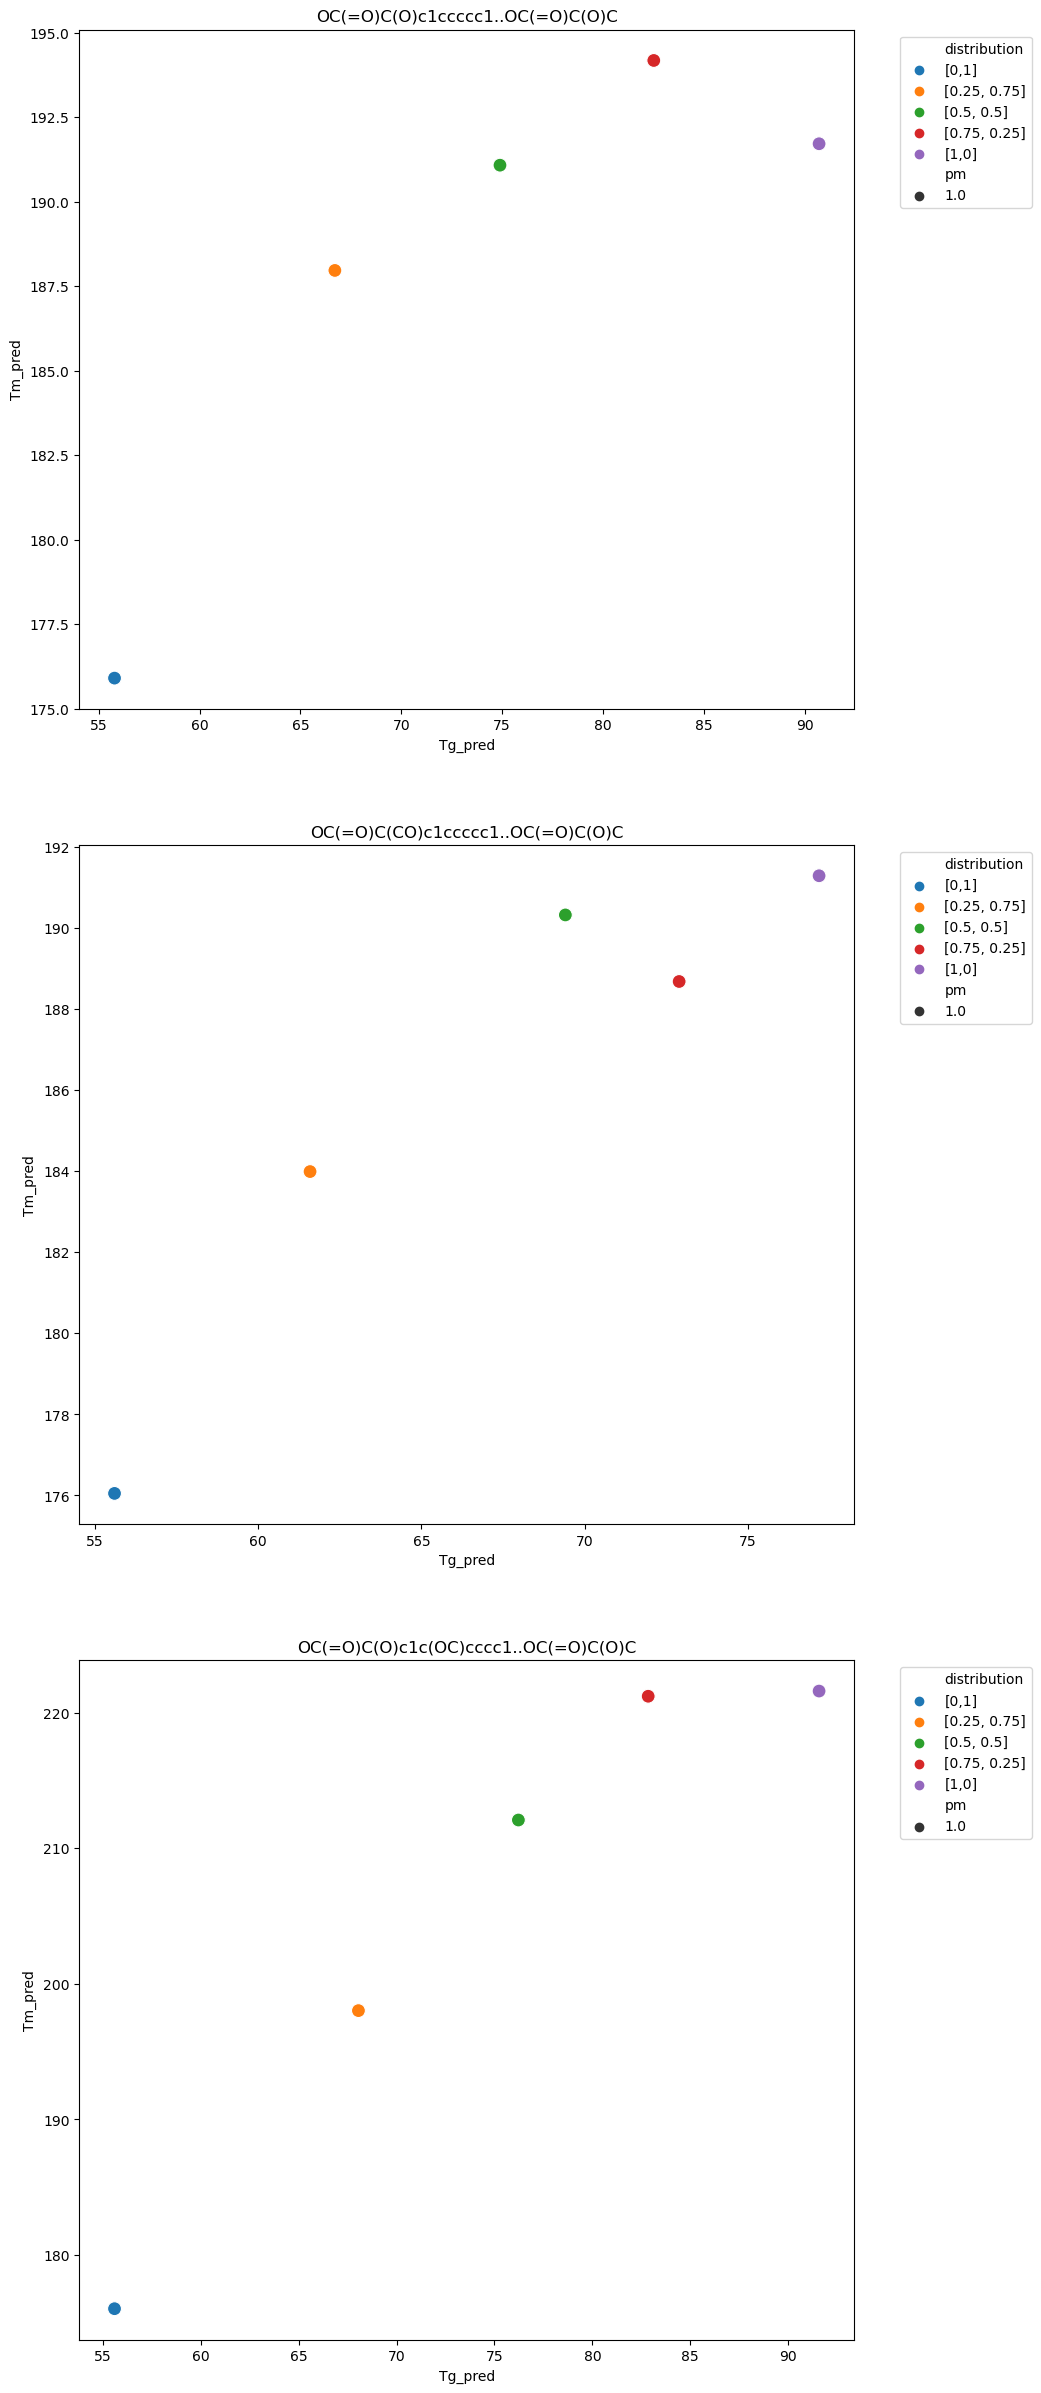

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 30))
gs = []
for ai, smi in enumerate(set(df_copo_predictions.smiles_monomer)):
    g = sns.scatterplot(x="Tg_pred", y="Tm_pred",
        data=df_copo_predictions[(df_copo_predictions.smiles_monomer==smi) & (df_copo_predictions.pm == 1)],
        hue="distribution", 
        style="pm", 
        s=100, 
        ax=ax[ai],
    )
    g.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    g.set_title(smi)
    gs.append(g)


Text(0.5, 1.0, 'OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C')

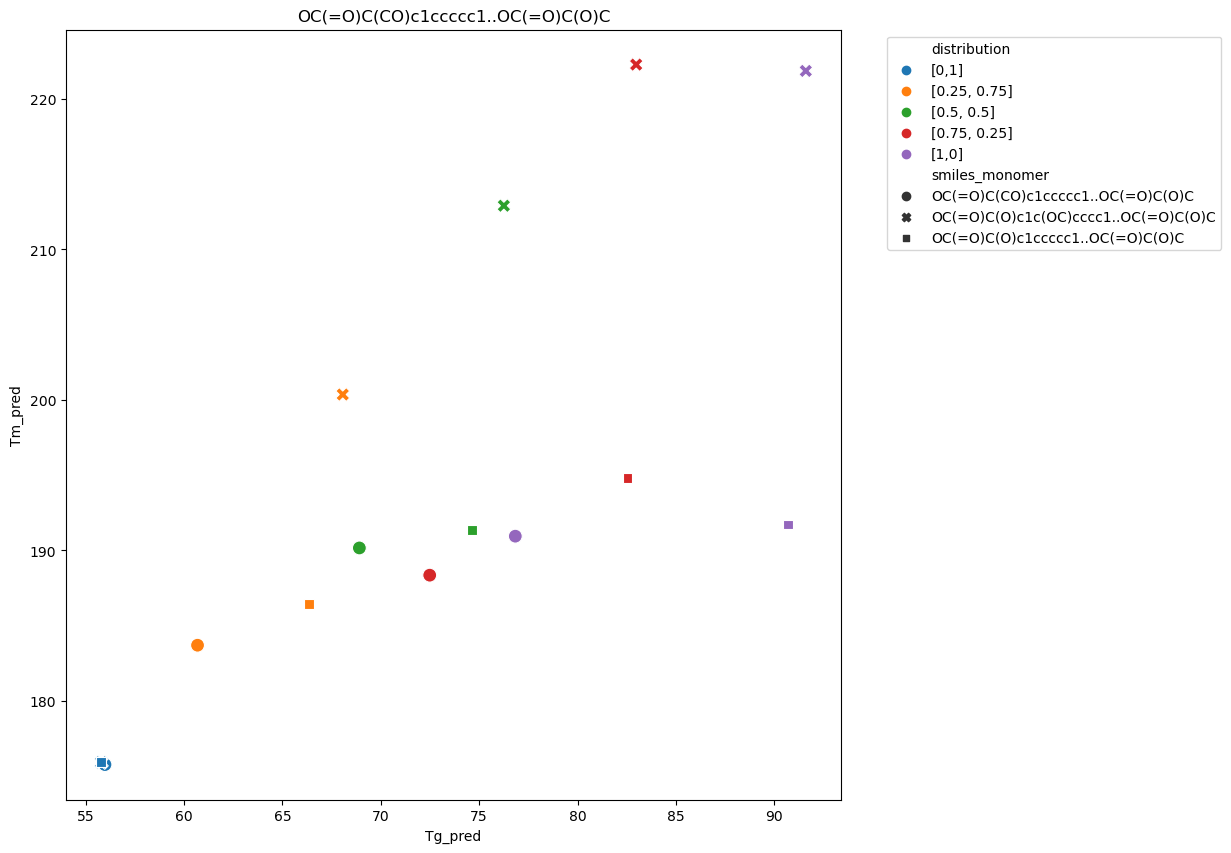

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
g = sns.scatterplot(x="Tg_pred", y="Tm_pred",
    data=df_copo_predictions[df_copo_predictions.pm == 1],
    hue="distribution", 
    style="smiles_monomer", 
    s=100, 
    ax=ax
)
g.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
g.set_title(smi)


In [68]:
df_copo_predictions

,smiles_monomer,pm,distribution,Tm_pred,Tg_pred,type
0,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,"[0,1]",167.489182,41.925285,copo
1,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,"[0.25, 0.75]",159.684387,58.510471,copo
2,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,"[0.5, 0.5]",162.467621,68.976418,copo
3,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,"[0.75, 0.25]",169.719849,77.379227,copo
4,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,"[1,0]",180.995026,88.963860,copo
5,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.5,"[0,1]",48.577923,20.552691,copo
6,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.5,"[0.25, 0.75]",81.163277,40.473862,copo
7,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.5,"[0.5, 0.5]",106.595909,53.977970,copo
8,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.5,"[0.75, 0.25]",128.016953,66.241119,copo
9,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.5,"[1,0]",161.688675,91.073494,copo


# Actual Plot in Paper

/var/folders/mn/k32kn37x5ldgpp51c6cdmkpm0000gn/T/ipykernel_14670/3176173619.py:109: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pdi" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("../MPNN_GB_Results.png", pdi=300, bbox_inches="tight")


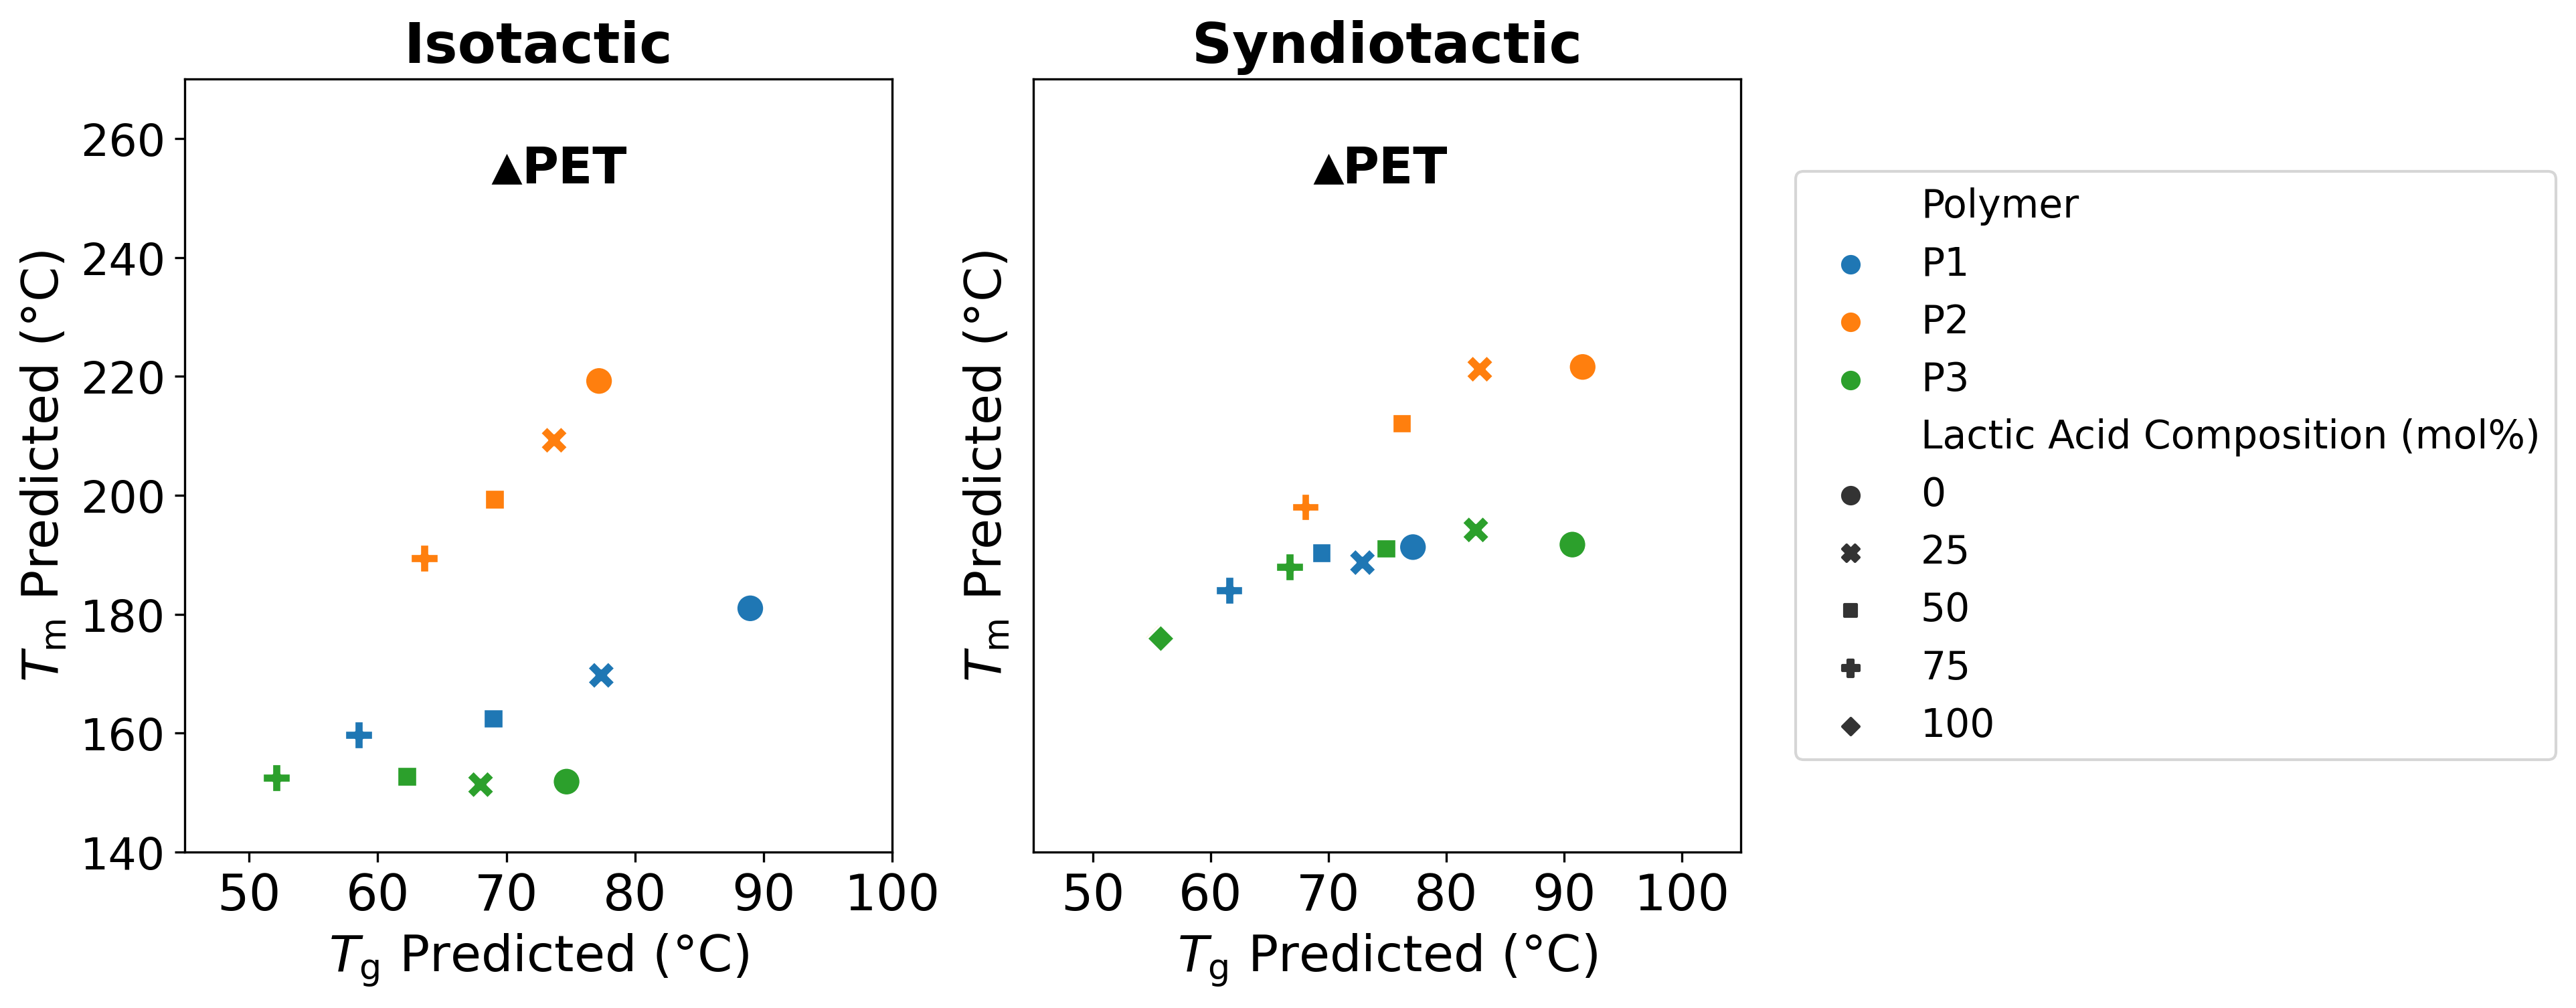

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_copo_predictions is your DataFrame
df_to_plot = df_copo_predictions.copy()

## Data Frame Manipulation
# Relabel Data Frame Values and Columns
ratio_remap = {"[0,1]": "100", "[0.25, 0.75]": "75", "[0.5, 0.5]": "50", "[0.75, 0.25]": "25", "[1,0]": "0"}
smiles_remap = {"OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C": "P1", "OC(=O)C(O)c1c(OC)cccc1..OC(=O)C(O)C": "P2", "OC(=O)C(O)c1ccccc1..OC(=O)C(O)C": "P3"}

df_to_plot['distribution'] = df_to_plot['distribution'].apply(lambda d: ratio_remap[d])
df_to_plot['smiles_monomer'] = df_to_plot['smiles_monomer'].apply(lambda s: smiles_remap[s])
df_to_plot = df_to_plot.rename(
    columns={"distribution": "Lactic Acid Composition (mol%)",
             "smiles_monomer": "Polymer"}
)

# Reorder Data Frame Values
composition_order = ['0', '25', '50', '75', '100']
polymer_order = ["P1", "P2", "P3"]
df_to_plot['Lactic Acid Composition (mol%)'] = pd.Categorical(df_to_plot['Lactic Acid Composition (mol%)'], categories=composition_order, ordered=True)
df_to_plot['Polymer'] = pd.Categorical(df_to_plot['Polymer'], categories=polymer_order, ordered=True)

## Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
s = 100
ds = 60

title_size = 20
label_size = 18
tick_size = 16
legend_size = 14
l_size = 18

# Isotactic Plot
g = sns.scatterplot(x="Tg_pred", y="Tm_pred",
                    data=df_to_plot[df_to_plot.pm == 0],
                    style="Lactic Acid Composition (mol%)",
                    hue="Polymer",
                    s=s,
                    legend=False,
                    ax=ax[0]
                    )

# PET
sns.scatterplot(x=[70], y=[255], marker="^", s=s+ds, color="k", ax=ax[0])
dx, dy = (1.2, -2)
an_format = dict(fontsize=l_size, weight="bold")
ax[0].annotate('PET', xy=(70+dx-0.05, 254.5+dy), **an_format)

# Title
g.set_title("Isotactic", size=title_size, fontweight="bold")

# X Axis
g.set_xlabel("$T_\mathrm{g}}$ Predicted (°C)", size=label_size)
g.set_xlim(45, 100)

# Y Axis
g.set_ylabel("$T_\mathrm{m}}$ Predicted (°C)", size=label_size)
g.set_ylim(140, 270)

ax[0].tick_params(axis='x', labelsize=label_size)
ax[0].tick_params(axis='y', labelsize=tick_size)
ax[0].set_xticks([50, 60, 70, 80, 90, 100])


# Syndiotactic Plot
g = sns.scatterplot(x="Tg_pred", y="Tm_pred",
                    data=df_to_plot[df_to_plot.pm == 1],
                    style="Lactic Acid Composition (mol%)",
                    hue="Polymer",
                    s=s,
                    ax=ax[1],
                    )

# PET
sns.scatterplot(x=[70], y=[255], marker="^", s=s+ds, color="k", ax=ax[1])
dx, dy = (1.2, -2)
an_format = dict(fontsize=l_size, fontweight='bold')
ax[1].annotate('PET', xy=(70+dx-0.05, 254.5+dy), **an_format)

# Legends
g.legend(
    bbox_to_anchor=(1.05, 0.5),
    loc='center left',
    fontsize=legend_size,
)

# Title
g.set_title("Syndiotactic", size=title_size, fontweight='bold')

# X Axis
g.set_xlabel("$T_\mathrm{g}}$ Predicted (°C)", size=label_size)
g.set_xlim(45, 105)

# Label Axis
g.set_ylabel("$T_\mathrm{m}}$ Predicted (°C)", size=label_size)
g.set_ylim(140, 270)
g.set_yticks([])
g.set_yticklabels("")

ax[1].tick_params(axis='x', labelsize=label_size)
ax[1].tick_params(axis='y', labelsize=tick_size)
ax[1].set_xticks([50, 60, 70, 80, 90, 100])

# plt.show()
plt.savefig("../MPNN_GB_Results.png", pdi=300, bbox_inches="tight")

In [111]:
df_to_plot

,smiles_monomer,pm,distribution,Tm_pred,Tg_pred
0,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,100,167.322556,42.146729
1,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,75,160.870209,58.335026
2,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,50,163.475266,69.357582
3,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,25,169.476852,77.185806
4,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.0,0,181.019699,88.968414
5,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.5,100,48.738529,20.590033
6,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.5,75,81.193886,41.003925
7,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.5,50,105.614120,53.047802
8,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.5,25,127.047791,64.958138
9,OC(=O)C(CO)c1ccccc1..OC(=O)C(O)C,0.5,0,161.785187,91.124313


# Plot Results

## Assign mapping to compounds

In [291]:
final_smiles = set(df_predictions[df_predictions.missing_bits <= 15].smiles_monomer.to_list())
df_predictions_DOV = df_predictions[df_predictions.missing_bits <= 15]

# mapping_dict = {
# 'C=CCOCC(O)CC(=O)O': "6s",
#  'CC(C)COC(CO)CC(=O)O': "5s",
#  'CC(C)COCC(O)CC(=O)O': "5p",
#  'CC(C)OC(CO)CC(=O)O': "4s",
#  'CC(C)OCC(O)CC(=O)O': "4p",
#  'CCCOC(CO)CC(=O)O': "3s",
#  'CCCOCC(O)CC(=O)O': "3p",
#  'CCOC(CO)CC(=O)O': "2s",
#  'CCOCC(O)CC(=O)O': "2p",
#  'COC(CO)CC(=O)O': "1s",
#  'COCC(O)CC(=O)O': "1p"
# }
def label(v):
    try:
        return mapping_dict[v]
    except:
        return
df_predictions["label"] = df_predictions_DOV.smiles_monomer.apply(lambda v: mapping_dict[v] if v in mapping_dict else v)

In [245]:
# # Label Polymers
# primary = "[C][C;H2][O;H1]"
# secondary = "CC([O;H1])C"

# def is_primary(smi):
#     mol = Chem.MolFromSmiles(smi)
#     patt = Chem.MolFromSmarts(primary)

#     if len(mol.GetSubstructMatch(patt)) > 0:
#         return True
#     else:
#         return False

# def is_secondary(smi):
#     mol = Chem.MolFromSmiles(smi)
#     patt = Chem.MolFromSmarts(secondary)

#     if len(mol.GetSubstructMatch(patt)) > 0:
#         return True
#     else:
#         return False

# def get_type_alcohol(smi):
#     if is_primary(smi) > 0:
#         return "Primary"
#     else:
#         return "Secondary"

# df_predictions["alcohol"] = df_predictions.smiles_monomer.map(get_type_alcohol)

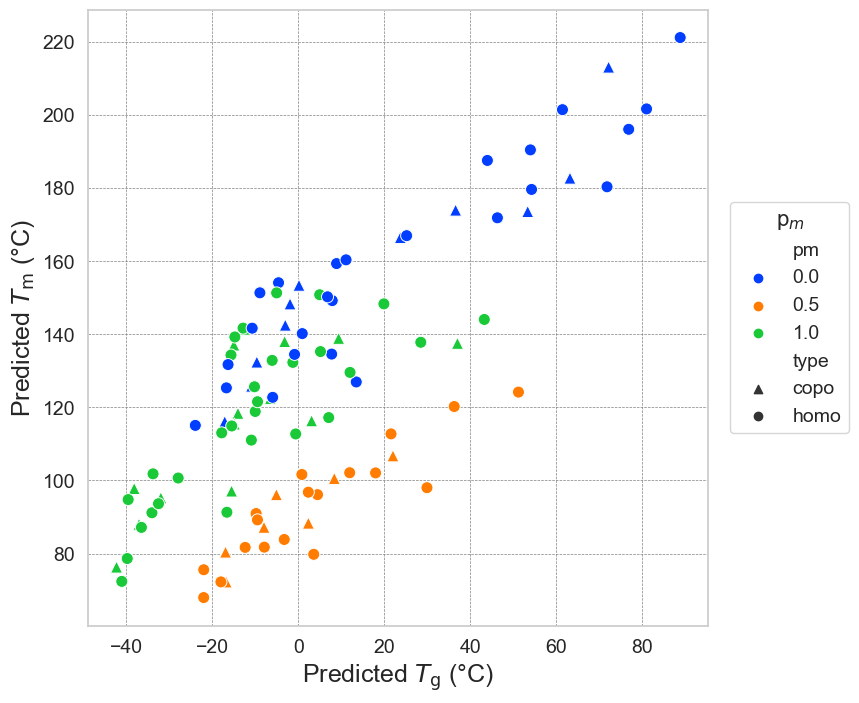

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a nice Seaborn style
sns.set(style="whitegrid")

# Create a figure and axis for better control
fig, ax = plt.subplots(figsize=(8, 8))

# Create the scatterplot
g = sns.scatterplot(
    x="Tg_pred", y="Tm_pred",
    data=df_predictions[df_predictions.missing_bits <= 15],
    style="type",
    hue="pm",
    s=75,
    palette="bright",  # You can choose a different color palette
    markers=["^", "o"],  # Specify markers for "homo" and "copo"
)

# Add a legend with a title
legend = ax.legend(title="p$_{m}$", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=14)
legend.get_title().set_fontsize(16)

# Set axis labels and plot title with subscripts
ax.set_xlabel(r'Predicted $T_{\mathrm{g}}$ (°C)', fontsize=18)
ax.set_ylabel(r'Predicted $T_{\mathrm{m}}$ (°C)', fontsize=18)
# ax.set_title('Pre Domain of Validity', fontsize=16)

# Customize tick label font size
ax.tick_params(labelsize=14)

# Customize the gridlines
ax.grid(which='major', linestyle='--', linewidth='0.5', color='gray')

# Show the plot
plt.savefig("../../../5_Figures/Epoxide/HomoCopoPredicted", dpi=300, bbox_inches='tight')

In [297]:
df_copo_predictions

,smiles_monomer,pm,Tm_pred,Tg_pred,missing_bits
0,C=CC(C)(C)OC(CO)CC(=O)O..C=CC(C)(C)OCC(O)CC(=O)O,0.0,164.004105,53.207954,16
1,C=CC(C)(C)OC(CO)CC(=O)O..C=CC(C)(C)OCC(O)CC(=O)O,0.5,97.148605,11.973975,20
2,C=CC(C)(C)OC(CO)CC(=O)O..C=CC(C)(C)OCC(O)CC(=O)O,1.0,122.390114,-6.482498,15
3,C=CCOC(CO)CC(=O)O..C=CCOCC(O)CC(=O)O,0.0,116.059036,-17.090597,15
4,C=CCOC(CO)CC(=O)O..C=CCOCC(O)CC(=O)O,0.5,66.960411,-25.003588,18
5,C=CCOC(CO)CC(=O)O..C=CCOCC(O)CC(=O)O,1.0,97.778885,-38.148842,10
6,CC(C)(C)OC(CO)CC(=O)O..CC(C)(C)OCC(O)CC(=O)O,0.0,182.693024,63.204750,13
7,CC(C)(C)OC(CO)CC(=O)O..CC(C)(C)OCC(O)CC(=O)O,0.5,106.723061,22.035131,14
8,CC(C)(C)OC(CO)CC(=O)O..CC(C)(C)OCC(O)CC(=O)O,1.0,137.998093,-3.167706,10
9,CC(C)COC(CO)CC(=O)O..CC(C)COCC(O)CC(=O)O,0.0,153.392532,0.180443,13


In [286]:
df_predictions

,smiles_monomer,pm,Tm_pred,Tg_pred,type,missing_bits,label
0,C=CC(C)(C)OC(CO)CC(=O)O..C=CC(C)(C)OCC(O)CC(=O)O,0.0,164.004105,53.207954,copo,NaN,C=CC(C)(C)OC(CO)CC(=O)O
1,C=CC(C)(C)OC(CO)CC(=O)O..C=CC(C)(C)OCC(O)CC(=O)O,0.5,97.148605,11.973975,copo,NaN,NaN
2,C=CC(C)(C)OC(CO)CC(=O)O..C=CC(C)(C)OCC(O)CC(=O)O,1.0,122.390114,-6.482498,copo,NaN,C=CC(C)(C)OC(CO)CC(=O)O
3,C=CCOC(CO)CC(=O)O..C=CCOCC(O)CC(=O)O,0.0,116.059036,-17.090597,copo,NaN,NaN
4,C=CCOC(CO)CC(=O)O..C=CCOCC(O)CC(=O)O,0.5,66.960411,-25.003588,copo,NaN,NaN
...,...,...,...,...,...,...,...
85,O=C(O)CC(O)COCc1ccccc1,0.5,75.947136,-7.459145,homo,19.0,NaN
86,O=C(O)CC(O)COCc1ccccc1,1.0,112.702713,-0.589970,homo,13.0,O=C(O)CC(O)COCc1ccccc1
87,O=C(O)CC(O)COCc1ccco1,0.0,126.166527,-9.138406,homo,17.0,NaN
88,O=C(O)CC(O)COCc1ccco1,0.5,67.445908,-16.970932,homo,21.0,NaN


In [146]:
df_predictions

,smiles_monomer,missing_bits,pm,Tm_pred,Tg_pred,label,alcohol
0,C=CCOC(CO)CC(=O)O,11.0,0.0,122.663620,-5.865781,C=CCOC(CO)CC(=O)O,Primary
1,C=CCOC(CO)CC(=O)O,13.0,0.5,72.271545,-17.969393,C=CCOC(CO)CC(=O)O,Primary
2,C=CCOC(CO)CC(=O)O,9.0,1.0,102.075233,-33.807034,C=CCOC(CO)CC(=O)O,Primary
3,C=CCOCC(O)CC(=O)O,15.0,0.0,115.050156,-23.939276,C=CCOCC(O)CC(=O)O,Secondary
4,C=CCOCC(O)CC(=O)O,18.0,0.5,62.601105,-29.883553,NaN,Secondary
...,...,...,...,...,...,...,...
67,O=C(O)CC(O)COCCc1ccccc1,22.0,0.5,78.487732,-3.290996,NaN,Secondary
68,O=C(O)CC(O)COCCc1ccccc1,16.0,1.0,111.334885,-0.432854,NaN,Secondary
69,O=C(O)CC(O)COCc1ccccc1,18.0,0.0,125.634544,4.168249,NaN,Secondary
70,O=C(O)CC(O)COCc1ccccc1,19.0,0.5,75.938080,-7.478093,NaN,Secondary


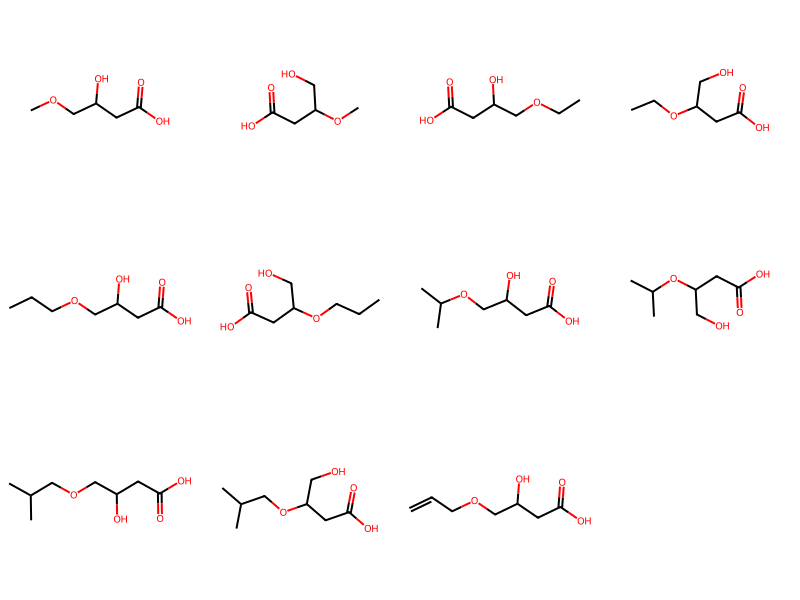

In [121]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in reversed(sorted(final_smiles))], molsPerRow=4, maxMols=50)

<AxesSubplot:xlabel='Tg_pred', ylabel='Tm_pred'>

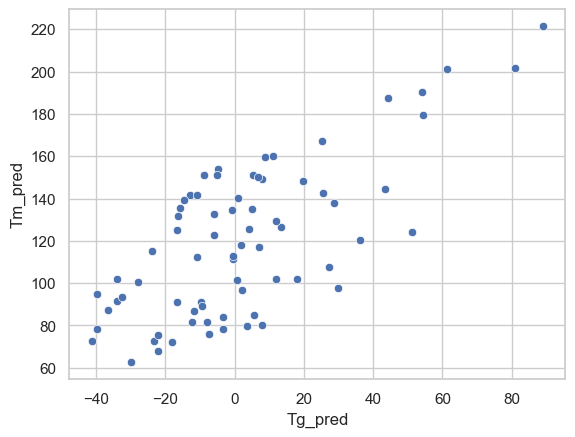

In [47]:
import seaborn as sns
df_predictions = df_predictions.groupby(by=["smiles_monomer", "pm"]).agg("mean").reset_index().loc[:, ["smiles_monomer", "pm", "Tm_pred", "Tg_pred"]].reset_index(drop=True)
sns.scatterplot(x="Tg_pred", y="Tm_pred", data=df_predictions)#, hue="Alcohol_Type")

In [165]:
df_predictions.sort_values(by=["Tm_pred"])

,smiles_monomer,pm,Tm_pred,Tg_pred
17,CCCCCOC(CO)CC(=O)O,1.0,72.109924,-43.189308
1,C=CCOC(CO)CC(=O)O,0.5,72.245232,-17.979607
20,CCCCOC(CO)CC(=O)O,1.0,78.562515,-39.780689
43,O=C(O)CC(CO)OCc1ccco1,0.5,79.462463,-3.692009
40,O=C(O)CC(CO)OCc1ccccc1,0.5,79.734573,3.599672
25,CCOC(CO)CC(=O)O,0.5,81.762650,-7.870553
16,CCCCCOC(CO)CC(=O)O,0.5,83.314064,-14.508963
37,O=C(O)CC(CO)OCCc1ccccc1,0.5,84.833031,5.763337
19,CCCCOC(CO)CC(=O)O,0.5,86.953529,-11.567986
22,CCCOC(CO)CC(=O)O,0.5,89.229424,-9.457809


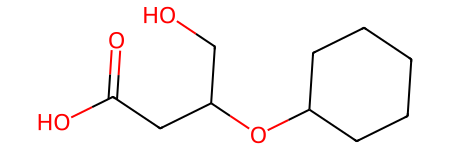

In [166]:
smi = "O=C(O)CC(CO)OC1CCCCC1"
AllChem.MolFromSmiles(smi)